# License

    Jupyter notebook for computing Pi using Monte Carlo sampling
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib notebook

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic
from Timer import Timer

In [2]:
%setup_logging
%cuda_context_handler context

Python version 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Registering context in user workspace
Creating context
PyCUDA version 2017.1.1
CUDA version (9, 1, 0)
Driver version 9010
Using 'GeForce 840M' GPU
 => compute capability: (5, 0)
 => memory: 1928 / 2048 MB available
Created context handle <917946394736>
Using CUDA cache dir c:\Users\anbro\Documents\projects\demos\MilanoGPU2018\notebooks\cuda_cache


In [3]:
cuda_kernel = """
__global__ void mandelbrot(float* output, unsigned int cols, float x0, float y0, float dx, float dy, int iterations) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    float x = i*dx + x0;
    float y = j*dy + y0;
    
    float2 z0 = make_float2(x, y);
    float2 z = z0;
    int k = 0;
    
    while (z.x*z.x + z.y*z.y < 25.0 && k < iterations) {
        float tmp = z.x*z.x - z.y*z.y + z0.x;
        z.y = 2*z.x*z.y + z0.y;
        z.x = tmp;
        ++k;
    }
    
    if (k < iterations) {
        output[j*cols+i] = fmod((k - log(log(sqrt(z.x*z.x+z.y*z.y))/log(5.0))/log(2.0)) / 100, 1.0);
    }
    else {
        output[j*cols+i] = 0.0f;
    }
}
"""
module = cuda_compiler.SourceModule(cuda_kernel, \
                                    options=['--use_fast_math'],
                                    #arch='compute_30', \
                                    #code='sm_37'
                                   )
mandelbrot_kernel = module.get_function("mandelbrot");

In [6]:
#Set block and grid size
n = 2048
domain_size = (3*n, 2*n)
block = (8, 8, 1)
grid = (int(domain_size[0]/block[0]), int(domain_size[1]/block[1]), 1)

x0 = -2
y0 = -1
dx = 3.0 / domain_size[0]
dy = 2.0 / domain_size[1]

#Allocate the output data on the GPU and on the CPU
output = np.empty((domain_size[1], domain_size[0]), dtype=np.float32)
output_gpu = GPUArray(output.shape, np.float32)

#Execute program on device
with Timer("kernel") as t:
    mandelbrot_kernel(output_gpu, np.int32(domain_size[0]),\
                      np.float32(x0), np.float32(y0), \
                      np.float32(dx), np.float32(dy), \
                      np.int32(1000), \
                      block=block, grid=grid)
    context.synchronize()

#Copy data from device to host
output_gpu.get(output)
pass

kernel: 355.875254 ms


<IPython.core.display.Javascript object>


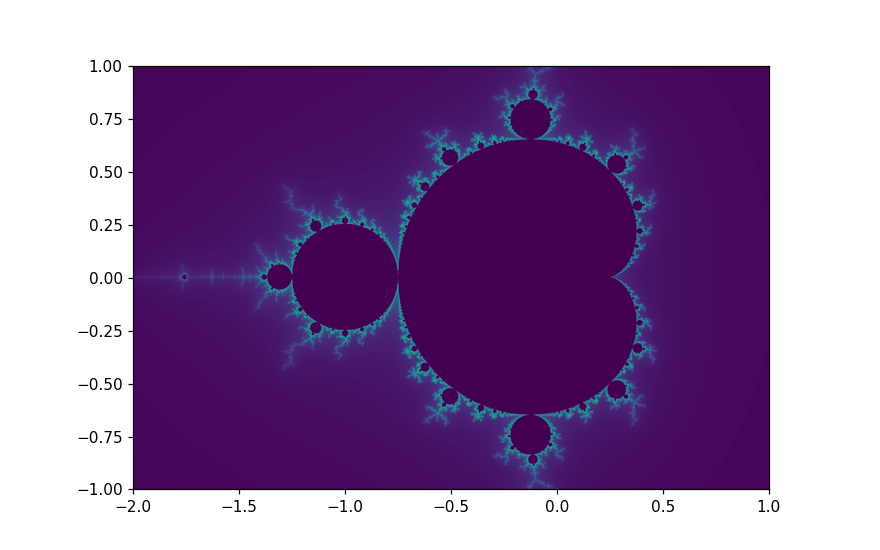

In [13]:
fig = plt.figure(figsize=(8, 5))
extent = [x0, x0+domain_size[0]*dx, y0, y0+domain_size[1]*dy]
plt.imshow(output, interpolation='spline16', origin='lower', extent=extent)
plt.show()